In [36]:
!rm -r hands_64/.ipynb_checkpoints
!ls hands_64/ -a   #to make sure that the deletion has occurred

ls: -a: No such file or directory
hands_64/:
class1


In [14]:
!pip install matplotlib
!pip install seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Original VAE

Description:

In [ ]:
import os
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
LATENT_DIM = 64
BATCH_SIZE = 64
EPOCHS = 30
IMAGE_SIZE = 64
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "hands_64_noBG"

# --- DATASET ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # Scales to [0, 1]
])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- VAE MODEL ---
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),  # 64→32
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(), # 32→16
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),# 16→8
            nn.Flatten(),
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),  # 8→16
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),   # 16→32
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()  # 32→64
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.fc_decode(z)
        x = self.decoder(x)
        return x, mu, logvar

# --- LOSS FUNCTION ---
def vae_loss(recon_x, x, mu, logvar):
    recon = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kld





In [9]:
import os
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
LATENT_DIM = 64
BATCH_SIZE = 64
EPOCHS = 30
IMAGE_SIZE = 64
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "hands_64_noBG"

# --- DATASET ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # Scales to [0, 1]
    # Ensure alpha channel is preserved
])

# Custom dataset loader to handle RGBA images
class RGBAImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = Image.open(path).convert("RGBA")  # Ensure RGBA format
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

dataset = RGBAImageFolder(root=DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- VAE MODEL ---
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 32, 4, 2, 1), nn.ReLU(),  # Input channels changed to 4
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(), # 32→16
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),# 16→8
            nn.Flatten(),
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),  # 8→16
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),   # 16→32
            nn.ConvTranspose2d(32, 4, 4, 2, 1), nn.Sigmoid()  # Output channels changed to 4
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(self.fc_decode(z))
        return x_recon, mu, logvar

# --- LOSS FUNCTION ---
def vae_loss(recon_x, x, mu, logvar):
    recon = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kld





### VAE with Convolutional Layers

In [2]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Sigmoid(),  # Output in range [0, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        # Decode
        x = self.fc_decode(z)
        x = x.view(x.size(0), 256, 4, 4)
        x = self.decoder(x)
        return x, mu, logvar

## VAE Training

In [10]:
# --- TRAINING ---
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    vae.train()
    total_loss = 0
    for batch, _ in dataloader:
        batch = batch.to(DEVICE)
        recon_batch, mu, logvar = vae(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataset):.4f}")

    # Save sample images every few epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            z = torch.randn(16, LATENT_DIM).to(DEVICE)
            sample = vae.decoder(vae.fc_decode(z)).cpu()
            utils.save_image(sample, f"vae_sample_noBG_epoch{epoch+1}.png", nrow=4)



Epoch 1/30, Loss: 853.4272
Epoch 2/30, Loss: 344.6214
Epoch 3/30, Loss: 269.5953
Epoch 4/30, Loss: 233.4389
Epoch 5/30, Loss: 211.2437
Epoch 6/30, Loss: 195.2699
Epoch 7/30, Loss: 184.2172
Epoch 8/30, Loss: 175.7593
Epoch 9/30, Loss: 168.0227
Epoch 10/30, Loss: 161.6360
Epoch 11/30, Loss: 156.0863
Epoch 12/30, Loss: 152.1067
Epoch 13/30, Loss: 148.8664
Epoch 14/30, Loss: 145.4051
Epoch 15/30, Loss: 142.3395
Epoch 16/30, Loss: 139.8619
Epoch 17/30, Loss: 137.6501
Epoch 18/30, Loss: 135.0838
Epoch 19/30, Loss: 133.4396
Epoch 20/30, Loss: 131.6407
Epoch 21/30, Loss: 129.7457
Epoch 22/30, Loss: 128.1730
Epoch 23/30, Loss: 127.1908
Epoch 24/30, Loss: 125.9609
Epoch 25/30, Loss: 124.3553
Epoch 26/30, Loss: 123.4076
Epoch 27/30, Loss: 122.3763
Epoch 28/30, Loss: 121.1554
Epoch 29/30, Loss: 120.1135
Epoch 30/30, Loss: 119.2958


### ConvVae Training

In [ ]:
# --- TRAINING ---
vae = ConvVAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    vae.train()
    total_loss = 0
    for batch, _ in dataloader:
        batch = batch.to(DEVICE)
        recon_batch, mu, logvar = vae(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataset):.4f}")

    # Save sample images every few epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            z = torch.randn(16, LATENT_DIM).to(DEVICE)
            decoded = vae.fc_decode(z)  # Output shape: [16, 4096]
            decoded = decoded.view(decoded.size(0), 256, 4, 4)  # Reshape to [16, 256, 4, 4]
            sample = vae.decoder(decoded).cpu()  # Pass reshaped tensor to decoder
            utils.save_image(sample, f"vae_sample_epoch{epoch+1}.png", nrow=4)

Epoch 1/30, Loss: 293.2606
Epoch 2/30, Loss: 150.2719
Epoch 3/30, Loss: 128.4034
Epoch 4/30, Loss: 114.6712
Epoch 5/30, Loss: 106.0823
Epoch 6/30, Loss: 98.4839
Epoch 7/30, Loss: 93.0307
Epoch 8/30, Loss: 88.2386
Epoch 9/30, Loss: 84.3331
Epoch 10/30, Loss: 81.2572
Epoch 11/30, Loss: 78.1414
Epoch 12/30, Loss: 76.3630
Epoch 13/30, Loss: 74.3731
Epoch 14/30, Loss: 72.5986
Epoch 15/30, Loss: 71.0483
Epoch 16/30, Loss: 69.9691
Epoch 17/30, Loss: 68.4609
Epoch 18/30, Loss: 67.2760
Epoch 19/30, Loss: 66.8200
Epoch 20/30, Loss: 65.3008
Epoch 21/30, Loss: 64.5622
Epoch 22/30, Loss: 63.9455
Epoch 23/30, Loss: 63.2946
Epoch 24/30, Loss: 62.5588
Epoch 25/30, Loss: 62.1024
Epoch 26/30, Loss: 61.0784
Epoch 27/30, Loss: 60.3490
Epoch 28/30, Loss: 60.0831
Epoch 29/30, Loss: 59.3355
Epoch 30/30, Loss: 59.1927


In [27]:
class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super(DCGANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0),  # 1x1 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Tanh(),  # Output in range [-1, 1]
        )

    def forward(self, z):
        return self.model(z.view(z.size(0), z.size(1), 1, 1))
    

class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super(DCGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),  # 4x4 -> 1x1
            nn.Sigmoid()  # Output a probability
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)  # Flatten output

In [30]:
##4 channels

class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super(DCGANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0),  # 1x1 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 4, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64 — RGBA (was 3)
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z.view(z.size(0), z.size(1), 1, 1))
    
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1),  # Change input channels from 3 to 4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [31]:
# --- MODEL INITIALIZATION ---
dcgan_generator = DCGANGenerator(latent_dim=LATENT_DIM).to(DEVICE)
dcgan_discriminator = DCGANDiscriminator().to(DEVICE)

optimizer_G = torch.optim.Adam(dcgan_generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dcgan_discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()

# --- TRAINING ---
for epoch in range(EPOCHS):
    dcgan_generator.train()
    dcgan_discriminator.train()
    total_g_loss = 0
    total_d_loss = 0

    for batch, _ in dataloader:
        batch = batch.to(DEVICE)
        batch_size = batch.size(0)

        batch += 0.05 * torch.randn_like(batch) # Add Gaussian noise to real images

        # --- Train Discriminator ---
        real_labels = torch.full((batch_size, 1), 0.9, device=DEVICE)  # Real labels = 0.9
        fake_labels = torch.zeros(batch_size, 1, device=DEVICE)       # Fake labels = 0.0

        # Real images
        real_loss = adversarial_loss(dcgan_discriminator(batch).view(-1, 1), real_labels)

        # Fake images
        z = torch.randn(batch_size, LATENT_DIM).to(DEVICE)
        fake_images = dcgan_generator(z)
        fake_loss = adversarial_loss(dcgan_discriminator(fake_images.detach()).view(-1, 1), fake_labels)

        # Total discriminator loss
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        # Generator tries to fool the discriminator
        g_loss = adversarial_loss(dcgan_discriminator(fake_images).view(-1, 1), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Generator Loss: {total_g_loss/len(dataloader):.4f}, Discriminator Loss: {total_d_loss/len(dataloader):.4f}")

    # Save sample images every few epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            z = torch.randn(16, LATENT_DIM).to(DEVICE)
            sample = dcgan_generator(z).cpu()
            utils.save_image(sample, f"dcgan_noBG_sample_epoch{epoch+1}.png", nrow=4)

Epoch 1/30, Generator Loss: 5.7736, Discriminator Loss: 0.4287
Epoch 2/30, Generator Loss: 6.3253, Discriminator Loss: 0.4398
Epoch 3/30, Generator Loss: 4.9630, Discriminator Loss: 0.4971
Epoch 4/30, Generator Loss: 3.4097, Discriminator Loss: 0.6484
Epoch 5/30, Generator Loss: 2.8061, Discriminator Loss: 0.6157
Epoch 6/30, Generator Loss: 2.7436, Discriminator Loss: 0.6854
Epoch 7/30, Generator Loss: 2.6247, Discriminator Loss: 0.6727
Epoch 8/30, Generator Loss: 2.6794, Discriminator Loss: 0.6574
Epoch 9/30, Generator Loss: 2.5927, Discriminator Loss: 0.6197
Epoch 10/30, Generator Loss: 2.7143, Discriminator Loss: 0.5872
Epoch 11/30, Generator Loss: 2.6457, Discriminator Loss: 0.6254
Epoch 12/30, Generator Loss: 2.6576, Discriminator Loss: 0.6187
Epoch 13/30, Generator Loss: 2.7306, Discriminator Loss: 0.6107
Epoch 14/30, Generator Loss: 2.6896, Discriminator Loss: 0.5343
Epoch 15/30, Generator Loss: 2.6736, Discriminator Loss: 0.7092
Epoch 16/30, Generator Loss: 2.6688, Discriminato

In [21]:
# --- MODEL INITIALIZATION ---
dcgan_generator = DCGANGenerator(latent_dim=LATENT_DIM).to(DEVICE)
dcgan_discriminator = DCGANDiscriminator().to(DEVICE)

optimizer_G = torch.optim.Adam(dcgan_generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dcgan_discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()

# --- TRAINING ---
for epoch in range(EPOCHS):
    dcgan_generator.train()
    dcgan_discriminator.train()
    total_g_loss = 0
    total_d_loss = 0

    for batch, _ in dataloader:
        batch = batch.to(DEVICE)
        batch_size = batch.size(0)

        batch += 0.05 * torch.randn_like(batch) # Add Gaussian noise to real images

        # --- Train Discriminator ---
        real_labels = torch.full((batch_size, 1), 0.9, device=DEVICE)  # Real labels = 0.9
        fake_labels = torch.zeros(batch_size, 1, device=DEVICE)       # Fake labels = 0.0

        # Real images
        real_loss = adversarial_loss(dcgan_discriminator(batch), real_labels)

        # Fake images
        z = torch.randn(batch_size, LATENT_DIM).to(DEVICE)
        fake_images = dcgan_generator(z)
        fake_loss = adversarial_loss(dcgan_discriminator(fake_images.detach()), fake_labels)

        # Total discriminator loss
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        # Generator tries to fool the discriminator
        g_loss = adversarial_loss(dcgan_discriminator(fake_images), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Generator Loss: {total_g_loss/len(dataloader):.4f}, Discriminator Loss: {total_d_loss/len(dataloader):.4f}")

    # Save sample images every few epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            z = torch.randn(16, LATENT_DIM).to(DEVICE)
            sample = dcgan_generator(z).cpu()
            utils.save_image(sample, f"dcgan_noBG_sample_epoch{epoch+1}.png", nrow=4)

ValueError: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.

### Save Model

In [18]:
# Save the generator and discriminator models after training
torch.save(dcgan_generator.state_dict(), "dcgan_generator.pth")
torch.save(dcgan_discriminator.state_dict(), "dcgan_discriminator.pth")

In [ ]:
import torch
from torchvision.utils import save_image
import numpy as np

# --- Load the Trained Generator ---
dcgan_generator = DCGANGenerator(latent_dim=LATENT_DIM).to(DEVICE)
dcgan_generator.load_state_dict(torch.load("dcgan_generator.pth"))
dcgan_generator.eval()  # Set to evaluation mode

# --- Generate Images by Varying Latent Dimensions ---
def generate_images_along_latent_dimensions(generator, latent_dim, num_variations=10, fixed_dim=0):
    """
    Generate images by varying a specific latent dimension.
    
    Args:
        generator: The trained generator model.
        latent_dim: The size of the latent space.
        num_variations: Number of variations along the latent dimension.
        fixed_dim: The index of the latent dimension to vary.
    """
    base_z = torch.randn(1, latent_dim).to(DEVICE)  # Base latent vector
    variations = torch.linspace(-3, 3, num_variations).to(DEVICE)  # Range of values for the dimension

    generated_images = []
    for value in variations:
        z = base_z.clone()  # Clone the base latent vector
        z[0, fixed_dim] = value  # Modify the specific latent dimension
        with torch.no_grad():
            generated_image = dcgan_generator(z).cpu()
            generated_images.append(generated_image)

    # Combine all generated images into a grid
    generated_images = torch.cat(generated_images, dim=0)
    save_image(generated_images, "latent_variations.png", nrow=num_variations, normalize=True)
    print("Generated images saved as 'latent_variations.png'.")

# --- Example Usage ---
generate_images_along_latent_dimensions(dcgan_generator, latent_dim=LATENT_DIM, num_variations=10, fixed_dim=0)


def generate_images_varying_multiple_dimensions(generator, latent_dim, num_variations=10, dims_to_vary=[0, 1]):
    base_z = torch.randn(1, latent_dim).to(DEVICE)
    variations = torch.linspace(-3, 3, num_variations).to(DEVICE)

    generated_images = []
    for value in variations:
        z = base_z.clone()
        for dim in dims_to_vary:
            z[0, dim] = value  # Modify multiple dimensions
        with torch.no_grad():
            generated_image = dcgan_generator(z).cpu()
            generated_images.append(generated_image)

    generated_images = torch.cat(generated_images, dim=0)
    save_image(generated_images, "latent_variations_multiple_dims.png", nrow=num_variations, normalize=True)
    print("Generated images saved as 'latent_variations_multiple_dims.png'.")

Generated images saved as 'latent_variations.png'.


In [31]:
!rm -r hands_64/.ipynb_checkpoints
!ls hands_64/ -a   #to make sure that the deletion has occurred

rm: hands_64/.ipynb_checkpoints: No such file or directory
ls: -a: No such file or directory
hands_64/:
hand_frames


In [19]:
# --- INTERPOLATION EXAMPLE ---
def interpolate(z1, z2, steps=10):
    vectors = []
    for alpha in torch.linspace(0, 1, steps):
        z = (1 - alpha) * z1 + alpha * z2
        vectors.append(z)
    return torch.stack(vectors)

with torch.no_grad():
    z1 = torch.randn(LATENT_DIM).to(DEVICE)
    z2 = torch.randn(LATENT_DIM).to(DEVICE)
    z_interp = interpolate(z1, z2, steps=8).to(DEVICE)  # [8, LATENT_DIM]

    decoded = vae.fc_decode(z_interp)  # [8, 128*8*8]
    imgs = vae.decoder(decoded).cpu()  # [8, 3, 64, 64]

    utils.save_image(imgs, "vae_interpolation.png", nrow=8)

print("Training complete.")

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv_transpose2d, but got input of size: [8, 4096]

In [14]:
def generate_from_random_direction(vae, scale=2.0):
    # Sample a random direction (unit vector) in latent space
    direction = torch.randn(LATENT_DIM)
    direction = direction / direction.norm()  # normalize to unit length
    z = (scale * direction).unsqueeze(0).to(DEVICE)  # shape: [1, LATENT_DIM]

    with torch.no_grad():
        decoded = vae.decoder(vae.fc_decode(z)).cpu()
    utils.save_image(decoded, "random_direction.png")

generate_from_random_direction(vae, scale=2.5)

In [15]:
def exaggerate_direction(vae, img, scale=3.0):
    vae.eval()
    img = img.to(DEVICE).unsqueeze(0)  # shape: [1, C, H, W]

    with torch.no_grad():
        _, mu, _ = vae(img)  # get mean vector
        direction = mu / mu.norm(dim=1, keepdim=True)  # normalize to unit direction
        z_exaggerated = direction * scale

        out = vae.decoder(vae.fc_decode(z_exaggerated)).cpu()
        utils.save_image(out, "exaggerated_hand_02.png")


example_img, _ = next(iter(dataloader))  # get one batch
exaggerate_direction(vae, example_img[30], scale=4.0)  # exaggerate features of that hand

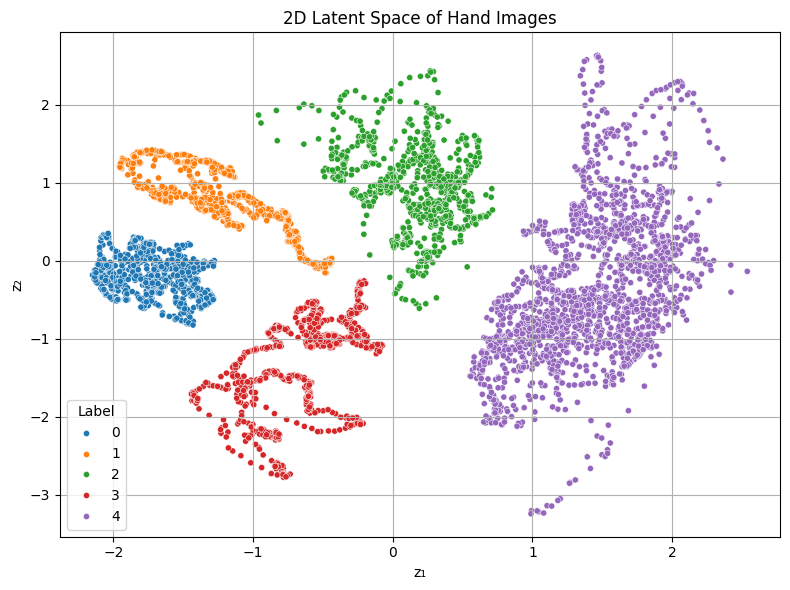

In [13]:
import matplotlib.pyplot as plt

vae.eval()
latents = []
labels = []

with torch.no_grad():
    for batch, label in dataloader:
        batch = batch.to(DEVICE)
        _, mu, _ = vae(batch)
        latents.append(mu.cpu())
        labels.append(label)

latents = torch.cat(latents)
labels = torch.cat(labels)

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=latents[:, 0], y=latents[:, 1], hue=labels, palette='tab10', s=20)
plt.title("2D Latent Space of Hand Images")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.legend(title="Label", loc="best")
plt.tight_layout()
plt.savefig("latent_space_2d.png")
plt.show()

In [12]:
import numpy as np

def generate_grid(vae, range_lim=3.0, steps=20):
    """Generates a 2D grid of decoded images over latent space"""
    lin = torch.linspace(-range_lim, range_lim, steps)
    z_grid = torch.stack([torch.cartesian_prod(lin, lin)])[0].to(DEVICE)  # shape: [steps*steps, 2]
    
    with torch.no_grad():
        decoded = vae.decoder(vae.fc_decode(z_grid)).cpu()

    grid_img = utils.make_grid(decoded, nrow=steps, padding=2)
    utils.save_image(grid_img, "latent_space_grid.png")

generate_grid(vae, range_lim=3.0, steps=20)

In [17]:
import torch
import numpy as np
from torchvision.utils import save_image
from PIL import Image
import os

DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

def walk_latent_space_gif(vae, start=None, direction=None, steps=30, step_size=0.5, gif_name="latent_walk_04.gif"):
    #LATENT_DIM = 2  # you must define this in your VAE model class

    if start is None:
        start = torch.zeros(LATENT_DIM).to(DEVICE)
    if direction is None:
        direction = torch.randn(LATENT_DIM).to(DEVICE)
        direction = direction / direction.norm()  # normalize

    os.makedirs("walk_frames", exist_ok=True)
    frames = []

    for i in range(steps):
        z = start + i * step_size * direction
        z = z.unsqueeze(0)  # batch size 1

        with torch.no_grad():
            x_hat = vae.decoder(vae.fc_decode(z)).cpu()
        
        frame_path = f"walk_frames/frame_{i:02d}.png"
        save_image(x_hat, frame_path)
        frames.append(Image.open(frame_path))

    # Save GIF
    frames[0].save(
        gif_name,
        save_all=True,
        append_images=frames[1:],
        duration=150,
        loop=0
    )
    print(f"GIF saved as {gif_name}")

# Example:
#direction = torch.tensor([0.0, 1.0]).to(DEVICE)
walk_latent_space_gif(vae, steps=30, step_size=1)

GIF saved as latent_walk_04.gif
